In [1]:
#!pip3 install tableschema 
#!pip3 install genson
#!pip3 install skinfer
#!pip3 install regex
#!pip3 install nltk
#!pip3
#!pip3 install word2number
#!pip3 install ticker
#!pip3 install finance
#!pip3 install plotpy
#!pip3 install kmodes

import nltk
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import pandas as pd 
import numpy as np
from word2number import w2n
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import regex as re
from nltk import word_tokenize, pos_tag, pos_tag_sents
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
#import plotly.graph_objs as go
#from matplotlib.finance import candlestick_ohlc

## Data Cleansing

In [2]:
data = pd.read_csv(r'Jobs.csv')
data.isna().any()
#data.replace('[0-9]+\\.','', regex=True)['Minimum Qual Requirements']

Job ID                           False
Agency                           False
Posting Type                     False
# Of Positions                   False
Business Title                   False
Civil Service Title              False
Title Code No                    False
Level                            False
Job Category                      True
Full-Time/Part-Time indicator     True
Salary Range From                False
Salary Range To                  False
Salary Frequency                 False
Work Location                    False
Division/Work Unit               False
Job Description                  False
Minimum Qual Requirements         True
Preferred Skills                  True
Additional Information            True
To Apply                          True
Hours/Shift                       True
Work Location 1                   True
Recruitment Contact               True
Residency Requirement             True
Posting Date                      True
Post Until               

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 28 columns):
Job ID                           3020 non-null int64
Agency                           3020 non-null object
Posting Type                     3020 non-null object
# Of Positions                   3020 non-null int64
Business Title                   3020 non-null object
Civil Service Title              3020 non-null object
Title Code No                    3020 non-null object
Level                            3020 non-null object
Job Category                     3018 non-null object
Full-Time/Part-Time indicator    2811 non-null object
Salary Range From                3020 non-null float64
Salary Range To                  3020 non-null float64
Salary Frequency                 3020 non-null object
Work Location                    3020 non-null object
Division/Work Unit               3020 non-null object
Job Description                  3020 non-null object
Minimum Qual Requirements    

### Normalization                            

In [4]:
# If Salary Frequency is Daily/Hourly then convert to Annual

# If Hourly, then multiply with 8 * 5 * 52 (8 hours a day, 5 days a week and 52 weeks an year)
data.loc[(data["Salary Frequency"] == 'Hourly'), "Salary Range From"] = data.loc[(data["Salary Frequency"] == 'Hourly'), 'Salary Range From'] * 8 * 5 * 52
data.loc[(data["Salary Frequency"] == 'Hourly'), "Salary Range To"] = data.loc[(data["Salary Frequency"] == 'Hourly'), 'Salary Range To'] * 8 * 5 * 52

# If Daily, then multiply with 5 * 52 (5 days a week and 52 weeks an year)
data.loc[(data["Salary Frequency"] == 'Daily'), "Salary Range From"] = data.loc[(data["Salary Frequency"] == 'Daily'), 'Salary Range From'] * 5 * 52
data.loc[(data["Salary Frequency"] == 'Daily'), "Salary Range To"] = data.loc[(data["Salary Frequency"] == 'Daily'), 'Salary Range To'] * 5 * 52

In [5]:
# Identification of Variables
# Highest paid skills in US Market requires Salary range From, Salary range To, Job Category, Minimum Qual Requirements, Preferred Skills

data = data[['Salary Range From', 'Salary Range To', 'Salary Frequency', 'Job Category', 'Minimum Qual Requirements', 'Preferred Skills']]

In [6]:
# Variable Selection

# highest paid Skills in the US market - Requires Salary From, Salary To, Preferred Skills
# Job categories, which involve above skills - Requires Job category, Preferred Skills
# To depicit different salary ranges based on job category and years of experience - Requires Salary From, Salary To, Minimum Qual Requirements 

In [7]:
# Missing values exists in below columns
#list(data.columns)
for missingcolumn in data.columns:
    if data[missingcolumn].isna().any() == True:
        print(missingcolumn)

Job Category
Minimum Qual Requirements
Preferred Skills


In [8]:
# Check if Salary From has Zero
# data[data['Salary Range From']==0]

data[data['Salary Range From']==0]

Salary Range From  Salary Range To Salary Frequency  \
904                 0.0          43079.0           Annual   
1350                0.0         155000.0           Annual   
1351                0.0         155000.0           Annual   
1533                0.0         100296.0           Annual   
1534                0.0         100296.0           Annual   
1804                0.0          69633.0           Annual   
1805                0.0          69633.0           Annual   
1945                0.0          90000.0           Annual   
1994                0.0         120000.0           Annual   
1995                0.0         120000.0           Annual   
2011                0.0         160000.0           Annual   
2012                0.0         160000.0           Annual   

                                   Job Category  \
904          Finance, Accounting, & Procurement   
1350              Technology, Data & Innovation   
1351              Technology, Data & Innovation   
1533              Technology, Data & Innovation   
1534              Technology, Data & Innovation   
1804  Legal Affairs Policy, Research & Analysis   
1805  Legal Affairs Policy, Research & Analysis   
1945              Technology, Data & Innovation   
1994              Technology, Data & Innovation   
1995              Technology, Data & Innovation   
2011              Technology, Data & Innovation   
2012              Technology, Data & Innovation   

                              Minimum Qual Requirements  \
904   Qualification Requirements  There are no forma...   
1350  A baccalaureate degree from an accredited coll...   
1351  A baccalaureate degree from an accredited coll...   
1533  1. A baccalaureate degree from an accredited c...   
1534  1. A baccalaureate degree from an accredited c...   
1804                                                NaN   
1805                                                NaN   
1945  1. A baccalaureate degree from an accredited c...   
1994  1. A baccalaureate degree from an accredited c...   
1995  1. A baccalaureate degree from an accredited c...   
2011  1. A baccalaureate degree from an accredited c...   
2012  1. A baccalaureate degree from an accredited c...   

                                       Preferred Skills  
904   1.  Knowledge and experience in Supply Chain M...  
1350  The preferred candidate should possess the fol...  
1351  The preferred candidate should possess the fol...  
1533  The preferred candidate should possess the fol...  
1534  The preferred candidate should possess the fol...  
1804                                                NaN  
1805                                                NaN  
1945  The preferred candidate should possess the fol...  
1994  The preferred candidate should possess the fol...  
1995  The preferred candidate should possess the fol...  
2011  Ã¢â‚¬Â¢\t  Strategic thought leadership in ove...  
2012  Ã¢â‚¬Â¢\t  Strategic thought leadership in ove...

In [9]:
# Update mean values for all Zero "Salary Range From" based on Job category
data1 = data[data['Salary Range From']==0]
data1 = data1["Job Category"].unique()

ind = 0

for ind in range(len(data1)) : 
    #data[(data['Job Category'] == data1[ind]) & (data['Salary Range From']  == 0 )]
    data[(data['Job Category'] == data1[ind]) & (data['Salary Range From']  == 0 )] = data[(data['Job Category'] == data1[ind])].mean()["Salary Range From"]


In [10]:
# No rows with 'Salary range from' with Zero are present
data[data['Salary Range From']==0]

Empty DataFrame
Columns: [Salary Range From, Salary Range To, Salary Frequency, Job Category, Minimum Qual Requirements, Preferred Skills]
Index: []

In [11]:
# Check if Salary To has Zero
data[data['Salary Range To']==0]

Empty DataFrame
Columns: [Salary Range From, Salary Range To, Salary Frequency, Job Category, Minimum Qual Requirements, Preferred Skills]
Index: []

In [12]:
# Check if Salary From is greater than Salary To
data[data['Salary Range From'] > data['Salary Range To']]

Empty DataFrame
Columns: [Salary Range From, Salary Range To, Salary Frequency, Job Category, Minimum Qual Requirements, Preferred Skills]
Index: []

### Special Characters Handling

In [13]:
# Handling special characters

data.replace('[0-9]+\\.','', regex=True)['Minimum Qual Requirements']

data.columns[data.isnull().any()] 
data = data.replace('[0-9]+\\.','', regex=True).replace('[^a-zA-Z0-9 ]',' ', regex = True)
#data['Job Description'] = data['Job Description'].str.lower()
data['Minimum Qual Requirements']= data['Minimum Qual Requirements'].str.lower()
data['Preferred Skills']=data['Preferred Skills'].str.lower()
data.size

18120

In [14]:
data = data.dropna(subset=['Salary Range From', 'Salary Range To', 'Job Category', 'Minimum Qual Requirements', 'Preferred Skills']) 

In [15]:
#data = data[(data['Salary Frequency'] =='Annual') & (data['Full-Time/Part-Time indicator']  =='F') & (data['Salary Range From'] > 0) & (data['Salary Range To']  >0)]
data = data[(data['Salary Range From'] > 0) & (data['Salary Range To']  >0)]

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556 entries, 2 to 3019
Data columns (total 6 columns):
Salary Range From            2556 non-null float64
Salary Range To              2556 non-null float64
Salary Frequency             2556 non-null object
Job Category                 2556 non-null object
Minimum Qual Requirements    2556 non-null object
Preferred Skills             2556 non-null object
dtypes: float64(2), object(4)
memory usage: 139.8+ KB


In [17]:
data.isna().any()

Salary Range From            False
Salary Range To              False
Salary Frequency             False
Job Category                 False
Minimum Qual Requirements    False
Preferred Skills             False
dtype: bool

In [18]:
data.describe().T

count          mean           std      min      25%  \
Salary Range From  2556.0  64033.236961  21141.818674  18200.0  52137.0   
Salary Range To    2556.0  92034.983424  36286.335371  21548.8  65640.0   

                       50%       75%       max  
Salary Range From  60435.0   74990.0  218587.0  
Salary Range To    84301.0  108657.0  234402.0

## Feature Engineering

In [19]:
min_range= 65729.400000
max_range = 90856.000000
df = data

df.loc[  (df['Salary Range From'] >= min_range ), 'Above_Min_Salary'] = 1
df.loc[~(df['Salary Range From'] >= min_range), 'Above_Min_Salary'] = 0

df.loc[ (df['Salary Range To'] <= max_range), 'Below_Max_Salary'] = 1
df.loc[~(df['Salary Range To'] <= max_range), 'Below_Max_Salary'] = 0

df['Above_Min_Salary'] = df['Above_Min_Salary'].astype(int)
df['Below_Max_Salary'] = df['Below_Max_Salary'].astype(int)

#df.head()

def calculateTfIdf(docs, count, tfidf):
    bag = count.fit_transform(docs)
    t = tfidf.fit_transform(bag)
    return bag, t

In [20]:
def create_documents(texts, flags):
    pos = ""
    neg = ""
    for (t,f1) in zip(texts.values, flags.values):
        if f1 >0 :
            pos = pos + t + " "
    
    return [pos]

def stats(count, tfidf, colName):
    df1 = pd.DataFrame(list(count.vocabulary_.items()),columns=['skills','id'])
    df1 = df1.sort_values('id').reset_index()
    dfx = pd.DataFrame(tfidf.toarray().T)
    dfx.columns = [colName]
    df1 = pd.concat([df1, dfx], axis=1)
    df1['diff'] = df1[colName]
    return df1



In [21]:
def getExperience(inputString):
    experience=0
    keywordlist = ['experience']
    words = word_tokenize(inputString)
    
    if re.search(r'experience',inputString):
        sen_tokenised= nltk.word_tokenize(inputString)
        tagged = nltk.pos_tag(sen_tokenised)
        entities = nltk.chunk.ne_chunk(tagged)
        grammar= r"""CHUNK:{<CD><NNS><IN><NN>}"""
        cp  =nltk.RegexpParser(grammar)
        result = cp.parse(tagged)
        for subtree in result.subtrees(filter=lambda t: t.label() == 'CHUNK'):
            for leaf in subtree:
                if leaf[1]=='CD':
                    
                    try:
                        experience=w2n.word_to_num(leaf[0])
                        if(experience> 100):
                            experience = 0
                    except:
                        print("An exception occurred")
    return experience

addwords = lambda x: getExperience(x)

In [22]:
tfidf = TfidfTransformer(use_idf = True, norm ='l2', smooth_idf = True)
count = CountVectorizer(stop_words='english',ngram_range=(1,1))
documents = create_documents(df['Preferred Skills'], df['Above_Min_Salary'])
wordBags, tfidf1 = calculateTfIdf(documents, count, tfidf)
df1 = stats(count,tfidf1,'tf-idf for above min salary')

In [23]:
df1.head()

index skills  id  tf-idf for above min salary      diff
0   3657    000   0                     0.001414  0.001414
1   3667   0593   1                     0.000236  0.000236
2   2975     08   2                     0.000471  0.000471
3   2976     09   3                     0.000471  0.000471
4    695     10   4                     0.017672  0.017672

In [24]:

tfidf = TfidfTransformer(use_idf = True, norm ='l2', smooth_idf = True)
count = CountVectorizer(stop_words='english',ngram_range=(1,1))

documents = create_documents(df['Preferred Skills'], df['Below_Max_Salary'])
wordBags, tfidf1 = calculateTfIdf(documents, count, tfidf)
df2 = stats(count,tfidf1,'tf-idf for below max salary')

In [25]:
df_merge_col = pd.merge(df1, df2, on='skills')

In [26]:
df_merge_col['final_diff']=df_merge_col['diff_x']-df_merge_col['diff_y']

In [27]:
skills_list = df_merge_col['skills'].tolist()

In [28]:
data['skills']= data[(data['Salary Range To'] <= max_range) & (data['Salary Range From'] >= min_range)]['Preferred Skills'].str.lower().str.split().apply(lambda x: [item for item in x if item in skills_list])

In [29]:
pd.set_option('display.max_rows', 10)
skills = data.loc[:, ['skills','Salary Range To','Salary Range From','Job Category']].explode('skills').dropna()
skills_jobCatgeory =  skills.loc[:, ['skills','Job Category']].drop_duplicates()
skills = pd.merge(skills, df_merge_col, on='skills', how='inner')
skills

skills  Salary Range To  Salary Range From  \
0      excellent          76814.4            66788.8   
1      excellent          76814.4            66788.8   
2      excellent          76814.4            66788.8   
3      excellent          76814.4            66788.8   
4      excellent          73576.0            73576.0   
...          ...              ...                ...   
15297       file          80046.0            69605.0   
15298     arabic          80046.0            69605.0   
15299     arabic          80046.0            69605.0   
15300     french          80046.0            69605.0   
15301     french          80046.0            69605.0   

                                            Job Category  index_x  id_x  \
0                                                 Health        4  1359   
1                                                 Health        4  1359   
2                                                 Health        4  1359   
3                                                 Health        4  1359   
4                                                 Health        4  1359   
...                                                  ...      ...   ...   
15297  Constituent Services   Community Programs Soci...     3535  1451   
15298  Constituent Services   Community Programs Soci...     3866   306   
15299  Constituent Services   Community Programs Soci...     3866   306   
15300  Constituent Services   Community Programs Soci...     3867  1521   
15301  Constituent Services   Community Programs Soci...     3867  1521   

       tf-idf for above min salary    diff_x  index_y  id_y  \
0                         0.135719  0.135719        7  1231   
1                         0.135719  0.135719        7  1231   
2                         0.135719  0.135719        7  1231   
3                         0.135719  0.135719        7  1231   
4                         0.135719  0.135719        7  1231   
...                            ...       ...      ...   ...   
15297                     0.001414  0.001414      535  1303   
15298                     0.000471  0.000471     1113   258   
15299                     0.000471  0.000471     1113   258   
15300                     0.000471  0.000471     1116  1367   
15301                     0.000471  0.000471     1116  1367   

       tf-idf for below max salary    diff_y  final_diff  
0                         0.186445  0.186445   -0.050725  
1                         0.186445  0.186445   -0.050725  
2                         0.186445  0.186445   -0.050725  
3                         0.186445  0.186445   -0.050725  
4                         0.186445  0.186445   -0.050725  
...                            ...       ...         ...  
15297                     0.002688  0.002688   -0.001274  
15298                     0.003456  0.003456   -0.002985  
15299                     0.003456  0.003456   -0.002985  
15300                     0.002304  0.002304   -0.001833  
15301                     0.002304  0.002304   -0.001833  

[15302 rows x 13 columns]

## Top 10 Skills

In [31]:
# Top 10 skills with salary range 

top10_skills= skills.loc[:, ['skills','Salary Range To','Salary Range From','final_diff']]
#top10_skills.reset_index(drop=False, inplace=True)
top10_skills= top10_skills.groupby("skills", as_index=False).max().nlargest(10,'final_diff')
top10_skills.loc[:, ['skills','Salary Range To','Salary Range From']]

skills  Salary Range To  Salary Range From
619     experience          90720.0            89520.0
1729         years          90720.0            89520.0
930     management          90720.0            89520.0
446         design          90418.0            80000.0
861      knowledge          90418.0            89180.0
1260       project          90147.2            80000.0
353   construction          90153.0            89180.0
1411      security          90000.0            89520.0
460    development          90153.0            85000.0
1484           sql          90000.0            80000.0

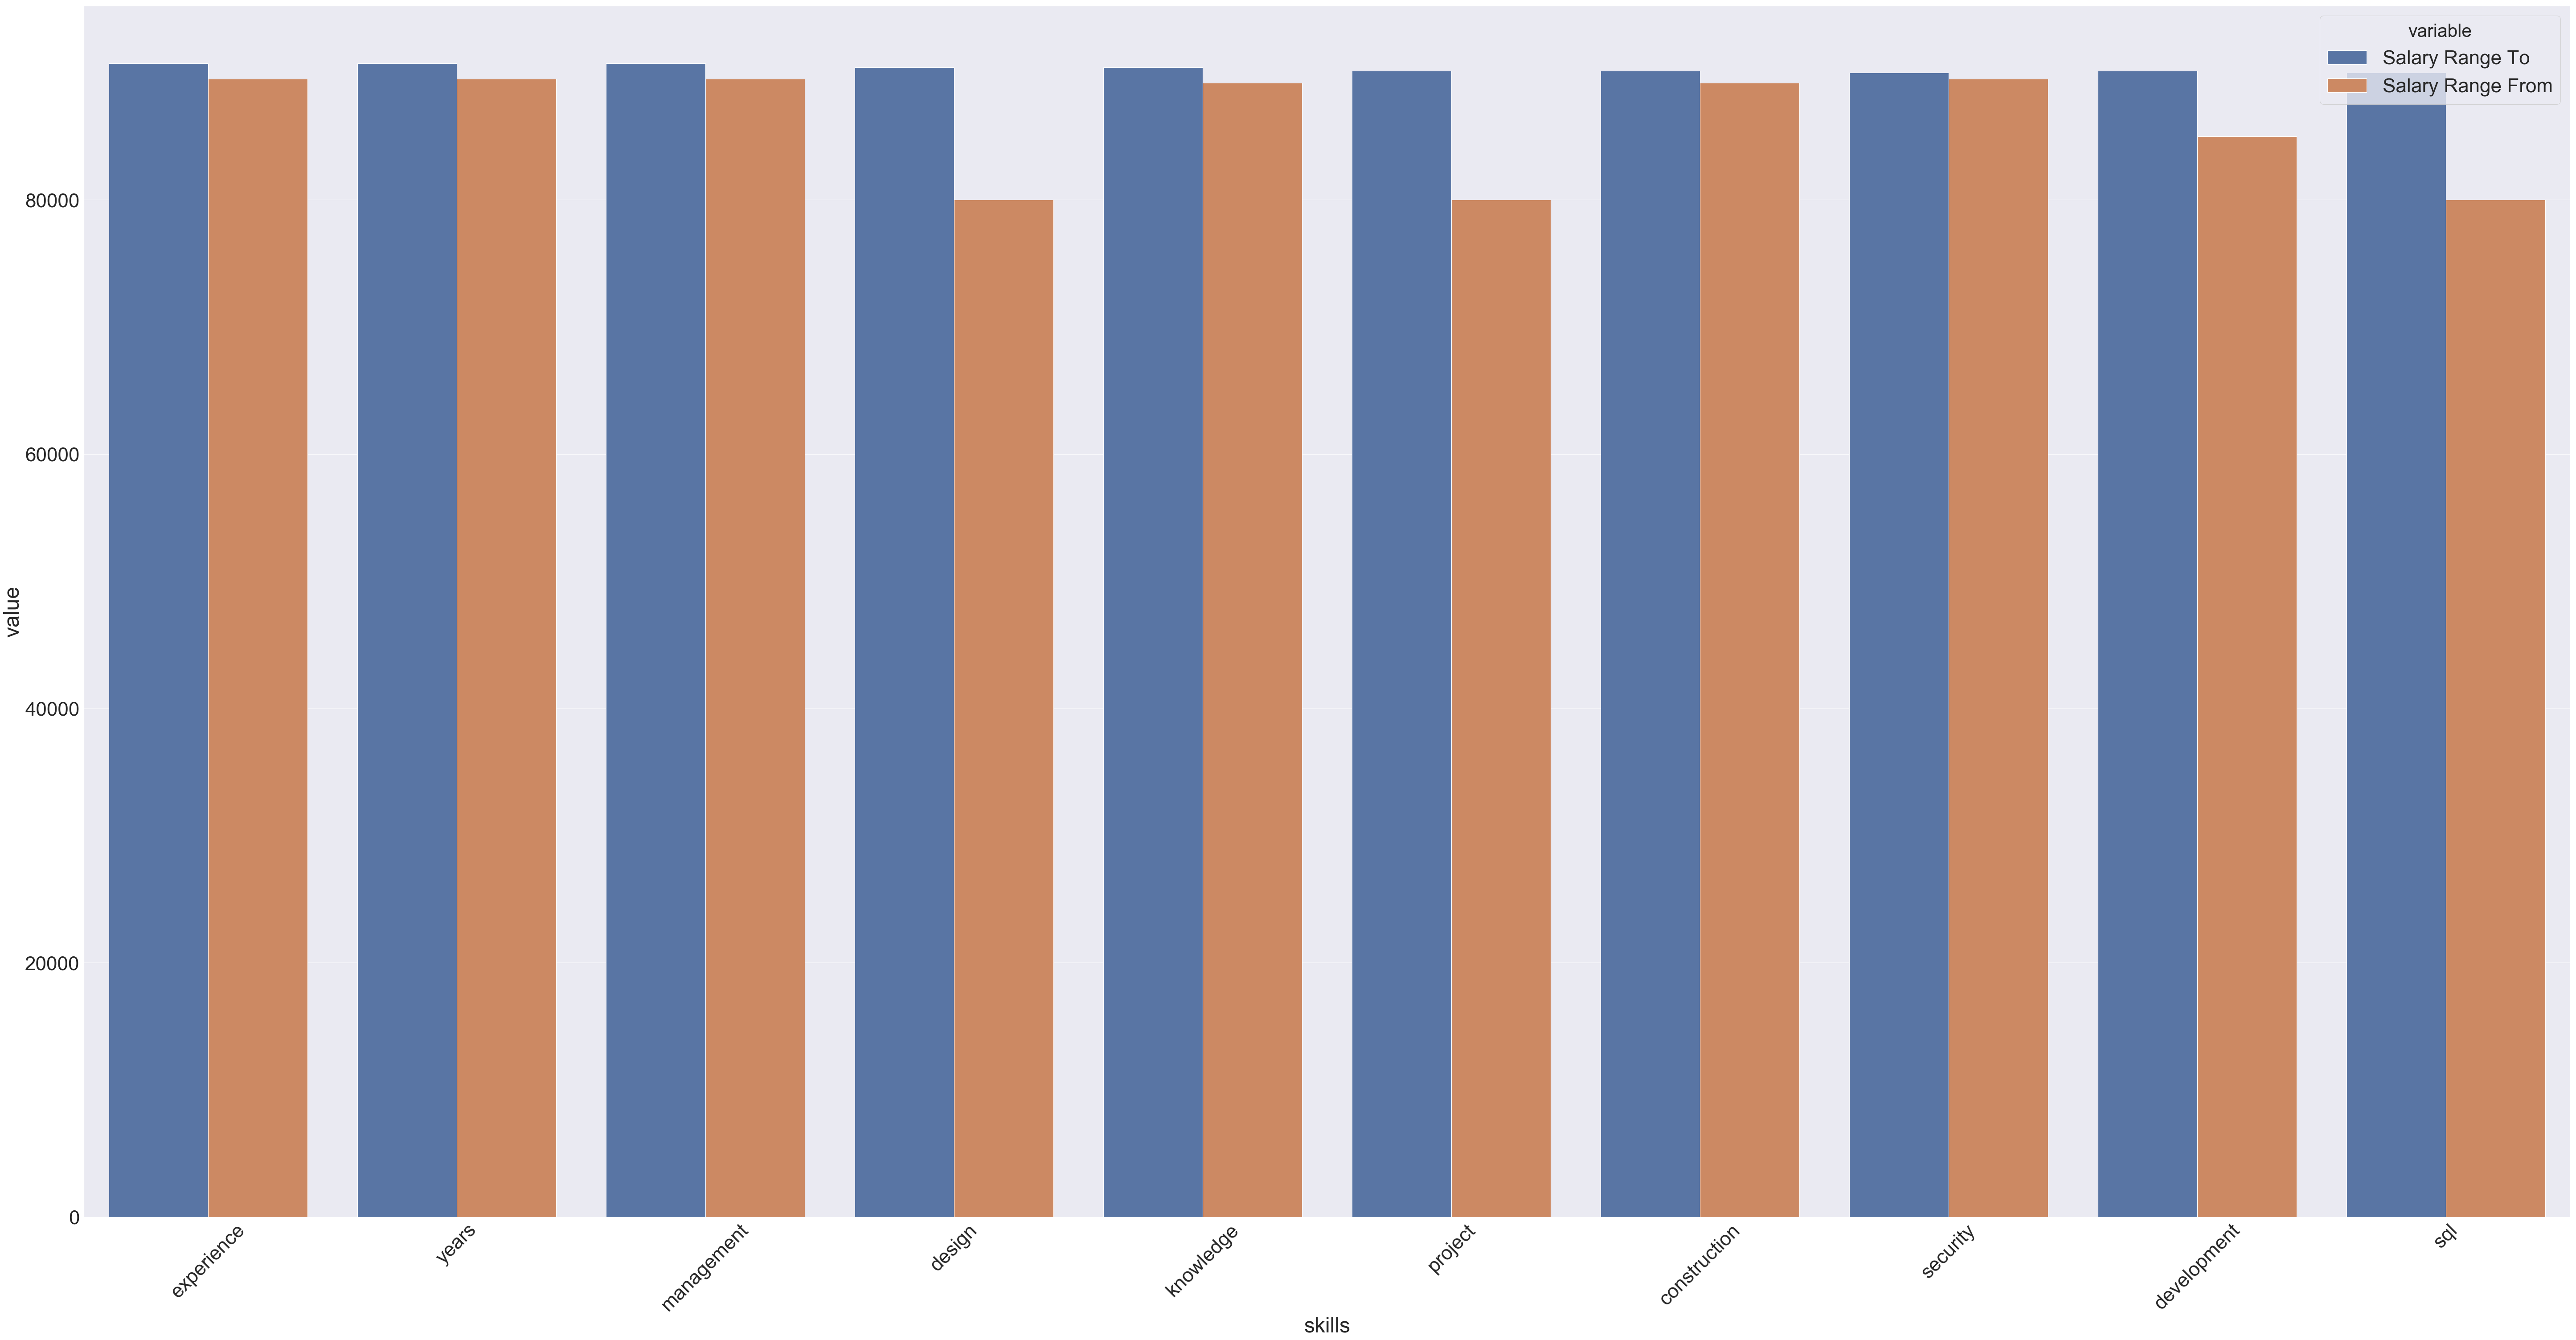

In [32]:
# Top 10 skills Graph 
# top10_skills

plt.figure(figsize=(100, 50))
sns.set(font_scale=4)
g_top10_skills = top10_skills.melt(id_vars='skills', value_vars=["Salary Range To", "Salary Range From"])
sns.barplot(x='skills', y='value', hue='variable', data=g_top10_skills)
plt.xticks(rotation=45)
plt.show()

## Top 10 Job category

In [38]:
top_category=pd.merge(skills_jobCatgeory, top10_skills, on='skills', how='inner').loc[:, ['final_diff','Job Category','Salary Range To','Salary Range From']].groupby("Job Category", as_index=False).max().nlargest(10,'final_diff')
top_category['Job Category']

0                      Administration   Human Resources
2     Administration   Human Resources Finance  Acco...
3     Administration   Human Resources Legal Affairs...
5      Administration   Human Resources Social Services
7     Administration   Human Resources Technology  D...
8                     Building Operations   Maintenance
9            Communications   Intergovernmental Affairs
10    Communications   Intergovernmental Affairs Pol...
11    Communications   Intergovernmental Affairs Pol...
12            Constituent Services   Community Programs
Name: Job Category, dtype: object

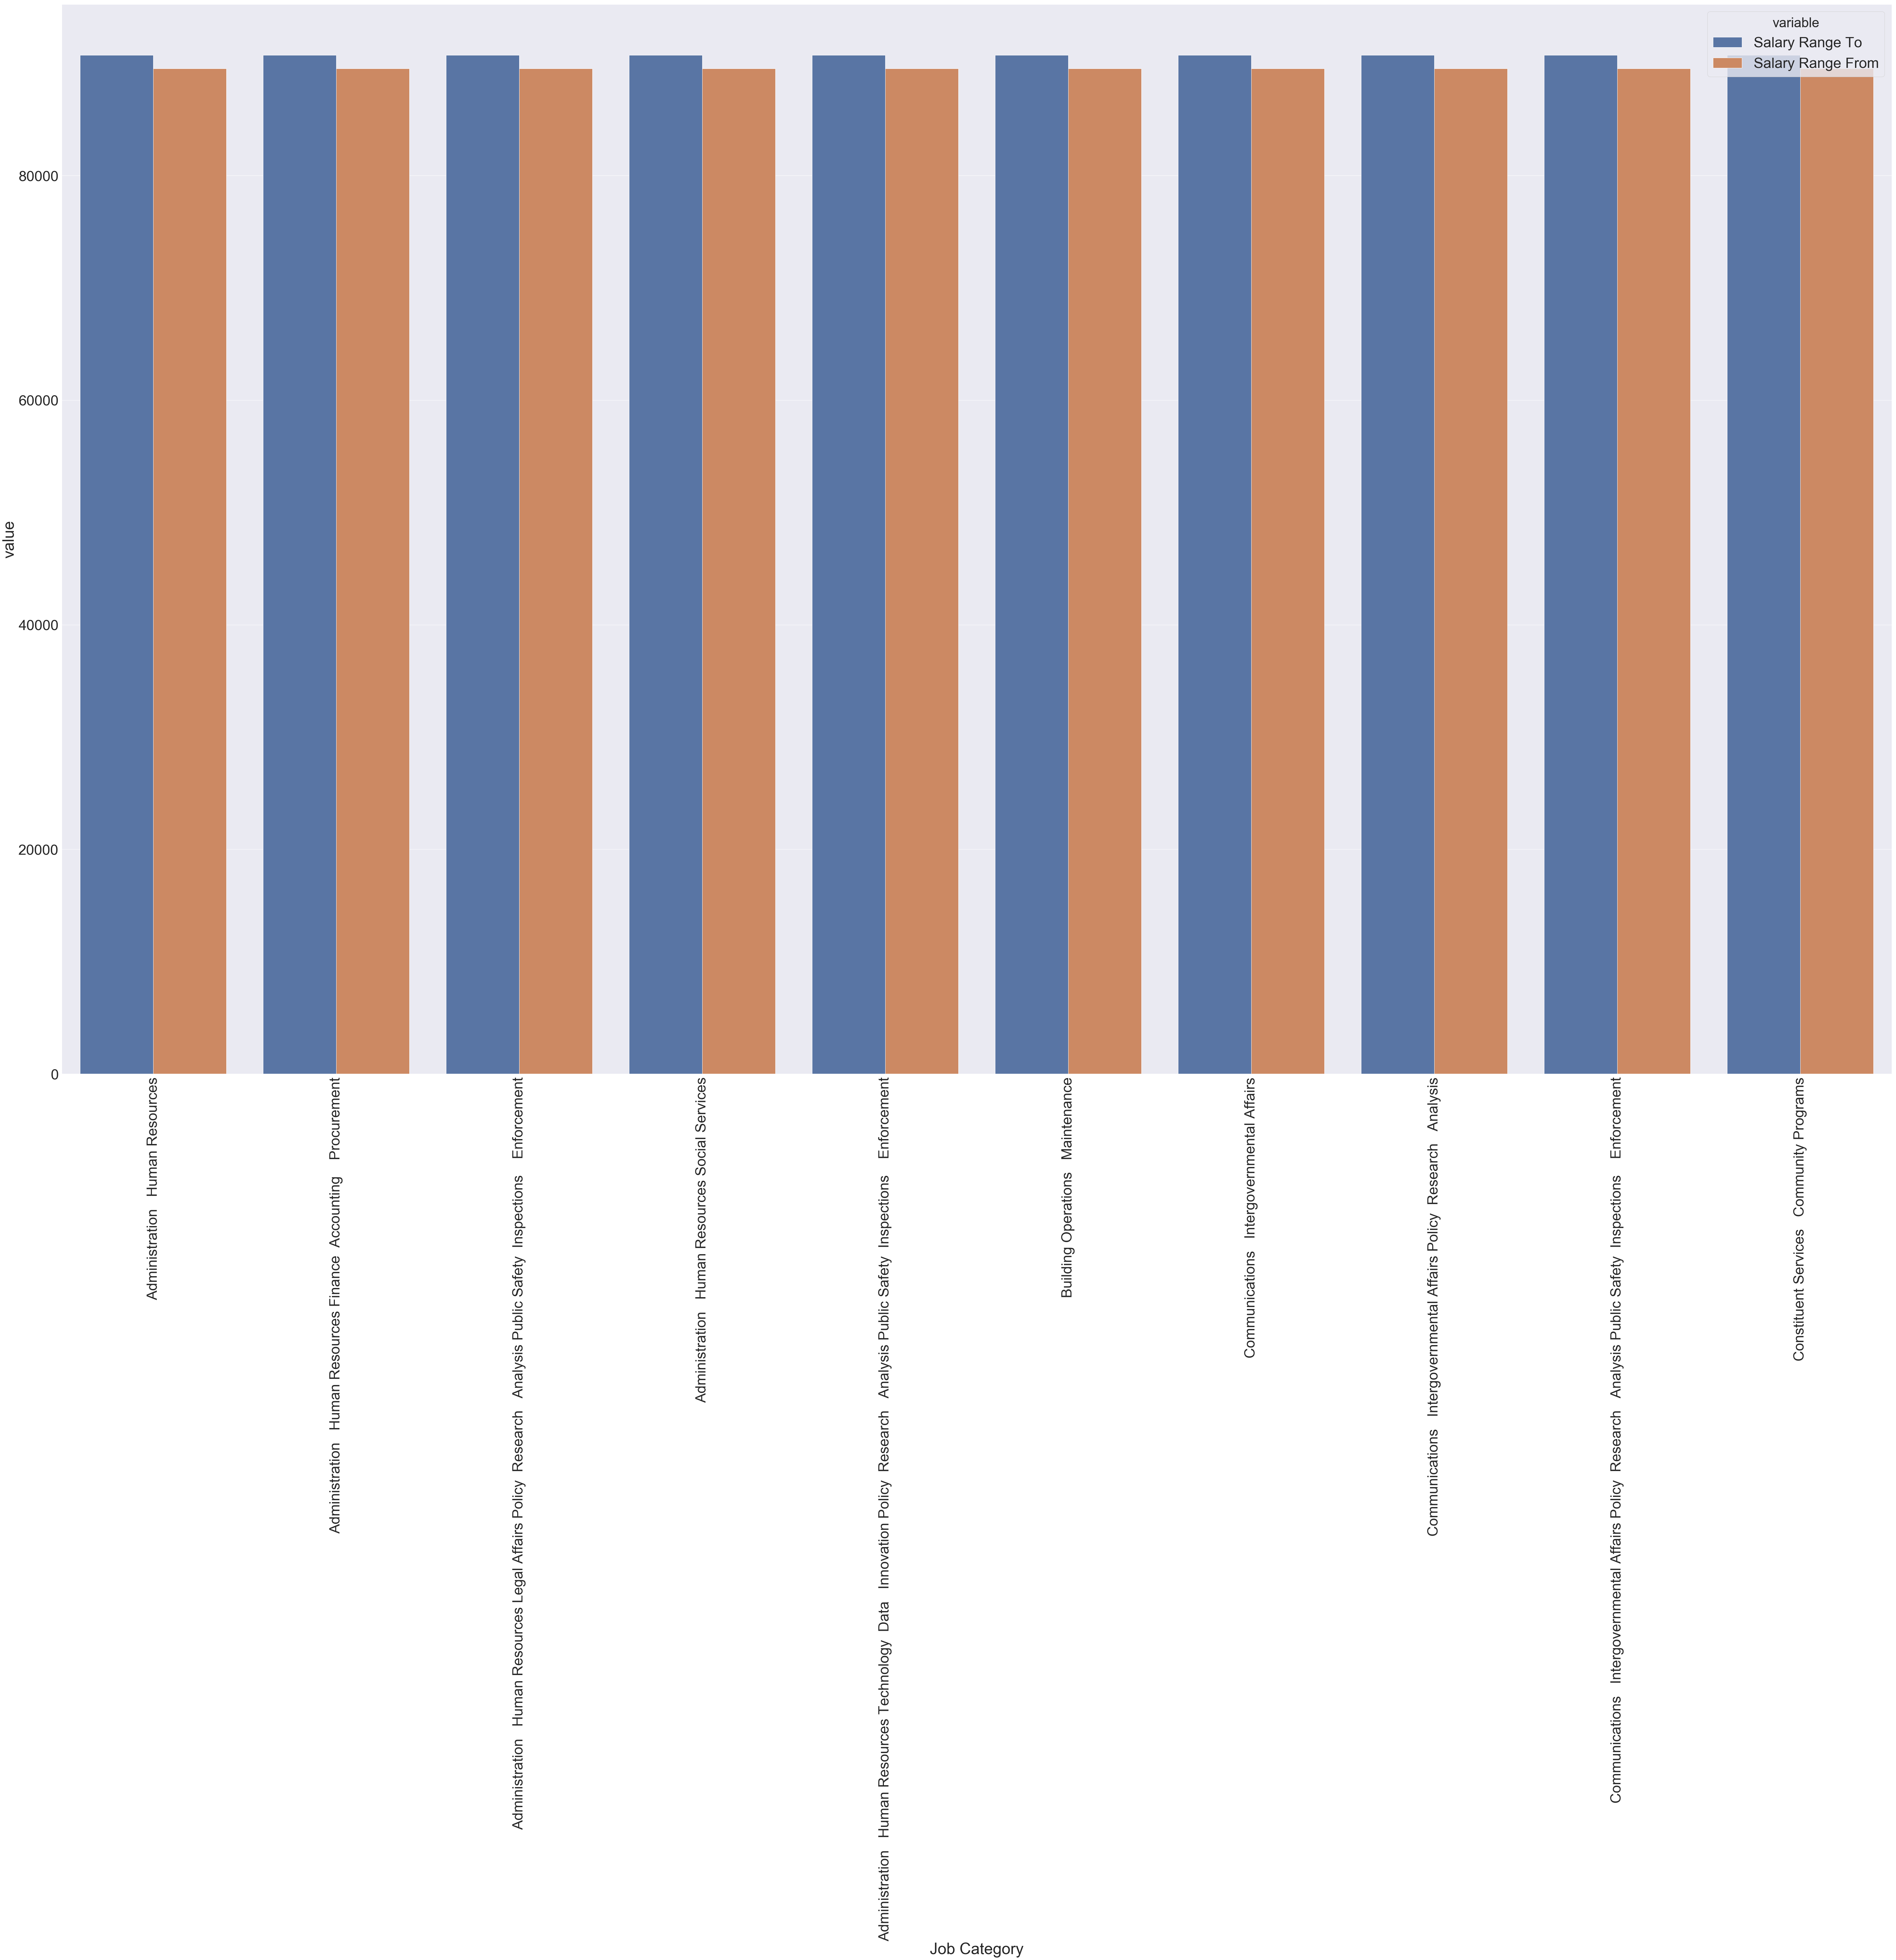

In [34]:
plt.figure(figsize=(100, 60))
sns.set(font_scale=4)
g_top_category = top_category.melt(id_vars='Job Category', value_vars=["Salary Range To", "Salary Range From"])

sns.barplot(x='Job Category', y='value', hue='variable', data=g_top_category)
plt.xticks(rotation=90)
plt.show()

## Plot  between Salary, Year of experience & Job category

In [36]:


df['experience'] = df[['Preferred Skills','Minimum Qual Requirements']].apply(lambda x: ''.join(x), axis=1).apply(addwords)
df['avg_salary'] = df[['Salary Range From', 'Salary Range To']].mean(axis=1)
df=df[['Job Category','experience','avg_salary']]

In [39]:
# Graph based on different salary ranges based on job category and years of experience

plt.figure(figsize=(200, 80))
df2 = df.nlargest(200,'avg_salary')
result= pd.pivot_table(df2, values='avg_salary', 
                    columns='Job Category', index=['experience'])
sns.set(font_scale=7.2)
sns.heatmap(result, annot=True, cmap="YlGnBu", fmt='g', linewidths=.1, linecolor='black',
                            cbar_kws={'label': 'Salary'})